# Qubit spectroscopy: Rabi measurement example
This notebook demonstrates how to perform a Rabi experiment on a simulated or real quantum device. This experiment tests the calibration of the `RX` pulse by rotating through a full $2\pi$ radians and evaluating the excited state visibility as a function of the angle of rotation, $\theta$. The QUIL program for one data point for qubit 0 at, for example $\theta=\pi/2$, is

    DECLARE ro BIT[1]
    X 0
    RX(pi/2) 0
    MEASURE 0 ro[0]
   
The X 0 is simply to initialize the state to $|1\rangle$. We expect to see a characteristic "Rabi flop" by sweeping $\theta$ over $[0, 2\pi)$, thereby completing a full rotation around the Bloch sphere. It should look like $\dfrac{1-\cos(\theta)}{2}$

setup

In [1]:
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer

from forest.benchmarking.qubit_spectroscopy import *

In [2]:
#qc = get_qc('Aspen-1-15Q-A')
qc = get_qc('2q-noisy-qvm') # will run on a QVM, but not meaningfully 
qubits = qc.qubits()
qubits

[0, 1]

## Generate simultaneous Rabi experiments on all qubits


In [3]:
import numpy as np
from numpy import pi
angles = np.linspace(0, 2*pi, 15)
rabi_expts = generate_rabi_experiments(qubits, angles)

## Acquire data

Collect our Rabi raw data using `acquire_qubit_spectroscopy_data`. 

In [4]:
results = acquire_qubit_spectroscopy_data(qc, rabi_expts, num_shots=500)

## Analyze and plot

**Use the results to fit a Rabi curve and estimate parameters**

In the cell below we first extract lists of expectations and std_errs from the results and store them separately by qubit. For each qubit we then fit to a sinusoid and evaluate the period (which should be $2\pi$). Finally we plot the Rabi flop.

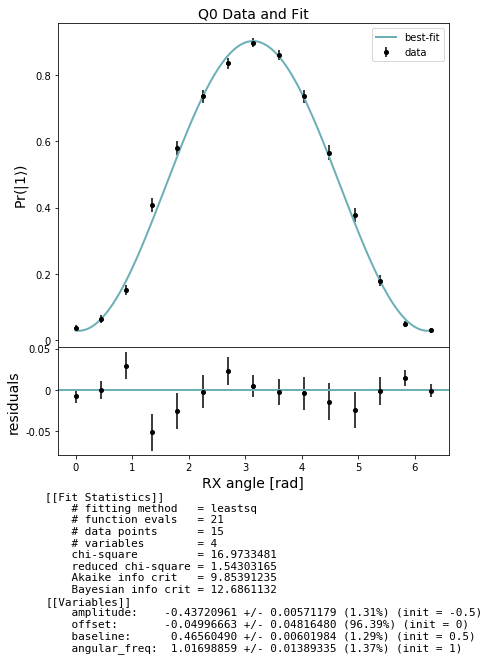

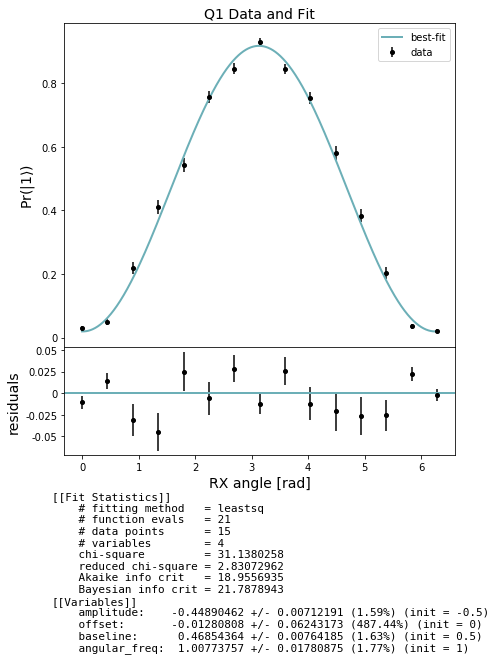

In [5]:
from forest.benchmarking.plotting import plot_figure_for_fit

stats_by_qubit = get_stats_by_qubit(results)
for q, stats in stats_by_qubit.items():
    fit = fit_rabi_results(angles, stats['expectation'], stats['std_err'])
    fig, axs = plot_figure_for_fit(fit, title=f'Q{q} Data and Fit', xlabel="RX angle [rad]",
                           ylabel=r"Pr($|1\rangle$)")
    angular_freq = fit.params['angular_freq'].value # ratio of actual angle over intended control angle
    amplitude = fit.params['amplitude'].value # (P(1 given 1) - P(1 given 0)) / 2
    baseline = fit.params['baseline'].value # amplitude + p(1 given 0)